## Classifier Model for Succesful Journey Prediction (Upsampling approach)
### Team Name : Data Crew

**Contributions:**
* Axel
* Darren
* Ryan
* Taro
* Dan

This notebook was created in order to implement, train and test the classifier model for the prediction of the successful journey of the customers. We are going to make several testing approaches were the seed 2024 is fixed in order to make all the code and the predictions comparable, the testing approaches are:

* Train test split
* Cross Validation in a Stratifield KFold and KFold

Additonally, as we are going to see further in the notebook, the data has a balancing problem and therefore we are going to use the following techniques in order to solve it:

* SMOTE
* ADASYN
* Up Sampling
* Down Sampling

In the cases were the models were trained using the unbalanced data set we are going to use the f1-score in order to measure the performance of the model, and in the cases were the models were trained using the balanced data set we are going to use the accuracy metric instead.

Finally it is worthwhile mentioning that in the case of the XGBoost model we used a hyperparameter optimization in order to find the best hyperparameters for the model with the Bayesian Optimization approach.

Model proposal: 
* XGBoost
* LGBM
* LR
* GB
* ADABoost
* Neural Network
* Random Forest

* Clustering for improving the accuracy of the models by looking at the errors
* Boosting algotithms are performing better
* Causationg learning
* Discover variable
* Analytics
* Markov Chain

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set_style('whitegrid')

# Librarie for Preprocessing (By Us)
from utils import *

# Model Libraries
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Model Selection and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# Optimización de hiperparámetros
import optuna
from skopt import BayesSearchCV
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder

# Reporting a progress bar
from tqdm import tqdm

# Downsample majority class
from sklearn.utils import resample
from sklearn.decomposition import PCA 

# standardize the data
from sklearn.preprocessing import StandardScaler

from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import Precision, Recall
from sklearn.metrics import f1_score
from keras.callbacks import Callback

from sklearn.metrics import accuracy_score, f1_score

#random.seed(2024)
np.random.seed(2024)

## Data

### Data Retrieval

We retrieve the data from the original source, i.e. the one that is uncleaned and unprocessed. Also we retrive the event definition dataset:

In [2]:
# Reading the dataset
new_dfx = pd.read_csv('../../1. Data/data_with_embeddings.csv')
new_dfx.head()

,num_journeys,max_journey,discover,number_accounts,one_more_journey,most_repeated_event,average_length_seq,approved_credit,has_prospecting,has_pre_application,...,time_embd_1,time_embd_2,time_embd_3,time_embd_4,event_embd_0,event_embd_1,event_embd_2,event_embd_3,event_embd_4,order_ships
0,2.0,91.0,0,2.0,1,4.0,60.5,1,1,0,...,0.0,0.0,0.291182,0.455151,0.0,0.0,0.0,0.097493,0.320596,1.0
1,1.0,63.0,0,1.0,0,4.0,58.0,1,1,0,...,0.0,0.0,0.158990,0.471587,0.0,0.0,0.0,0.115039,0.345468,0.0
2,1.0,27.0,1,1.0,0,4.0,24.0,1,1,0,...,0.0,0.0,0.135561,0.472970,0.0,0.0,0.0,0.117902,0.353426,0.0
3,1.0,8.0,1,1.0,0,4.0,6.0,1,1,0,...,0.0,0.0,0.048505,0.028250,0.0,0.0,0.0,0.019101,0.048565,0.0
4,1.0,11.0,1,1.0,0,19.0,11.0,1,0,0,...,0.0,0.0,0.059422,0.103953,0.0,0.0,0.0,0.043307,0.145620,0.0


### Separating the columns by type

In this subsection what we are doing is making a list of the columns that are going to be used for the model and then we are going to separate them by type, i.e. numericaL, categorical and boolean.

In [3]:
num_cols = ['num_journeys', 'max_journey', 'number_accounts', 'average_length_seq', 
            'time_in_discover', 'time_in_apply', 'time_max', 'time_mean', 'time_std', 
            'total_time_spent', 'event_embd_0', 'event_embd_1', 'event_embd_2', 
            'event_embd_3','event_embd_4', 'time_embd_0', 'time_embd_1', 'time_embd_2',
            'time_embd_3', 'time_embd_4']

categorical_cols = ['most_repeated_event', 'initial_device']
boolean_cols = ['discover', 'one_more_journey', 'approved_credit', 'has_prospecting', 'has_pre_application']
target = 'order_ships'

### Splitting the data into train and test

Here we have two different approaches of splitting the data into train and test:

* The first approach is to gather a sample of the data from the 0 class of the size of the class 1. Then we sample the class 1 with replacement. Those samples are our train set. The test is the whole dataset.

* The second approach is to use the train_test_split function from the sklearn library and set the stratify parameter to the target variable.

In [4]:
## Our approach
X_train, X_test, y_train, y_test = train_test_split(new_dfx.drop(columns='order_ships'), 
                                                    new_dfx.order_ships, 
                                                    test_size=0.2,
                                                    stratify=new_dfx.order_ships,
                                                    random_state=2024)

# Resetting the index
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

### Standardizing the data

In this section we are going to standardize the data in order to have a better performance of the models. We are only transforming those numerical variables exluiding the ones that are boolean and categorical (even when they have numbers as values).

In [5]:
numerical = X_train.loc[:,num_cols]

scaler = StandardScaler()
scaler.fit(numerical)
numerical_tran = scaler.transform(numerical)
numerical_test = scaler.transform(X_test[num_cols])

# Concatenate the data to the final dataframe
numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1)

### Balancing the data

#### Upsampling the data

If we want to approach the problem of the unbalanced data we can upsample the minority class in order to have a balanced dataset. But in order to do this we have to split the data into train and test and then upsample the train data.

In [6]:
df_majority = X_train[y_train == 0]
df_minority = X_train[y_train == 1]

print('Shape of majority class:', df_majority.shape)
print('Shape of minority class:', df_minority.shape)

Shape of majority class: (1075484, 27)
Shape of minority class: (256501, 27)


In [7]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=1075484,    # to match majority class
                                 random_state=2024)

# Combine majority class with upsampled minority class
X_train = pd.concat([df_majority, df_minority_upsampled])
y_train = [0]*1075484 + [1]*1075484

# X_train = np.array(X_traian)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

In [8]:
y_train = pd.DataFrame(y_train, columns=['order_ships'])
y_test = pd.DataFrame(y_test, columns=['order_ships'])

## Neural Network Model

* We first proceed by splitting the X_train and y_train into train and validation sets.

In [9]:
# Getting the validation set
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train, 
                                                              y_train, 
                                                              test_size=0.2,
                                                              stratify=y_train,
                                                              random_state=2024)

* Then we compute the class weights in order to solve the unbalanced data problem while training our models

In [10]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.values.reshape(-1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class weights:", class_weights_dict)

Class weights: {0: 1.0, 1: 1.0}


#### Model Architecture and Approach 1 (Best one so far)

In [11]:
model_1 = Sequential([
    Dense(512, activation='relu', input_shape=(27,)),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),  # Dropout layer to prevent overfitting
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),  # Dropout layer to prevent overfitting
    Dense(31, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    #Dropout(0.),  # Dropout layer to prevent overfitting
    Dense(1, activation='sigmoid')
])

learning_rate = 0.001 
optimizer = Adam(learning_rate=learning_rate)
model_1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
class_weights = {0: 0.6192491008699339, 1: 2.596451865684734} 

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               14336     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [12]:
# Fit the model
history = model_1.fit(X_train_nn, y_train_nn, 
                    epochs=5, 
                    batch_size=128,
                    validation_data=(X_val_nn, y_val_nn),
                    class_weight=class_weights_dict)

Epoch 1/5


2024-03-17 21:04:40.790609: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13444/13444 [==============================] - 43s 3ms/step - loss: 0.4123 - accuracy: 0.8483 - val_loss: 0.3410 - val_accuracy: 0.8645
Epoch 2/5
13444/13444 [==============================] - 40s 3ms/step - loss: 0.3429 - accuracy: 0.8639 - val_loss: 0.3339 - val_accuracy: 0.8655
Epoch 3/5
13444/13444 [==============================] - 41s 3ms/step - loss: 0.3340 - accuracy: 0.8668 - val_loss: 0.3208 - val_accuracy: 0.8726
Epoch 4/5
13444/13444 [==============================] - 42s 3ms/step - loss: 0.3283 - accuracy: 0.8683 - val_loss: 0.3169 - val_accuracy: 0.8719
Epoch 5/5
13444/13444 [==============================] - 40s 3ms/step - loss: 0.3242 - accuracy: 0.8697 - val_loss: 0.3117 - val_accuracy: 0.8743


In [13]:
from sklearn.metrics import accuracy_score, f1_score

# Make predictions
predictions = model_1.predict(X_test)

# Convert predictions to binary labels
binary_predictions = (predictions > 0.5).astype(int)

# Accuracy
accuracy = accuracy_score(y_test, binary_predictions.reshape(-1))
print('Accuracy:', accuracy)

f1 = f1_score(y_test, binary_predictions.reshape(-1))
print('F1 Score:', f1)

10407/10407 [==============================] - 5s 485us/step
Accuracy: 0.8426202037856196
F1 Score: 0.6939683614895444


## XGBoost Model

We can see that the class proportion is not balanced, but we are going to use the **scale_pos_weight** parameter in the XGBoost model in order to balance the classes. One quick rule of thumb to consider is that the scale_pos_weight should be equal to the ratio of the number of negative class to the positive class.

$$scale\_pos\_weight = \frac{negatives}{positives}$$

and therefore:

$$scale\_pos\_weight = \frac{negatives}{positives} = \frac{1344699}{320675} = 4.1933390504$$

### Hyperparameter Fine-Tuning Function For XGBoost

The next function is going to be used in order to fine-tune the hyperparameters of the XGBoost model by employing a strategy called Tree-structured Parzen Estimator (TPE). The TPE algorithm is a Bayesian optimization algorithm that explores the hyperparameter space efficiently.

In [14]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials 
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from typing import Any, Dict, Union

def hyperparameter_tuning(space: Dict[str, Union[float, int]], X_train: pd.DataFrame, y_train: pd.Series,
                    X_test: pd.DataFrame, y_test: pd.Series,
                    early_stopping_rounds: int=50,
                    metric:callable=accuracy_score) -> Dict[str, Any]:
    """
    Perform hyperparameter tuning for an XGBoost classifier.
    This function takes a dictionary of hyperparameters, training
    and test data, and an optional value for early stopping rounds,
    and returns a dictionary with the loss and model resulting from
    the tuning process. The model is trained using the training
    data and evaluated on the test data. The loss is computed as
    the negative of the accuracy score.
    Parameters
    ----------
    space : Dict[str, Union[float, int]]
        A dictionary of hyperparameters for the XGBoost classifier.
    X_train : pd.DataFrame
        The training data.
    y_train : pd.Series
        The training target.
    X_test : pd.DataFrame
        The test data.
    y_test : pd.Series
        The test target.
    early_stopping_rounds : int, optional
        The number of early stopping rounds to use. The default value
        is 50.
    metric : callable
        Metric to maximize. Default is accuracy
    Returns
    -------
    Dict[str, Any]
        A dictionary with the loss and model resulting from the
        tuning process. The loss is a float, and the model is an
        XGBoost classifier.
    """
    int_vals = ['max_depth', 'reg_alpha']
    
    space = {k: (int(val) if k in int_vals else val)
             for k,val in space.items()}
    
    space['early_stopping_rounds'] = early_stopping_rounds
    
    model = XGBClassifier(**space)
    evaluation = [(X_train, y_train),
                    (X_test, y_test)]
    model.fit(X_train, y_train,
              eval_set=evaluation,
              verbose=False)
    
    pred = model.predict(X_test)
    score = f1_score(y_test, pred)
    
    return {'loss': -score, 'status': STATUS_OK, 'model': model}

* Performing the hyperparameter optimization

In [15]:
# Hyperparameter space
options = {'max_depth': hp.quniform('max_depth', 1, 30, 1), # tree
           'min_child_weight': hp.loguniform('min_child_weight', -5, 5),
           'subsample': hp.uniform('subsample', 0.5, 1), # stochastic
           'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
           'reg_alpha': hp.uniform('reg_alpha', 0, 15),
           'reg_lambda': hp.uniform('reg_lambda', 1, 15),
           'gamma': hp.loguniform('gamma', -10, 10), # regularization
           'learning_rate': hp.loguniform('learning_rate', -7, 0), # boosting
           'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 50),
           'random_state': 2024,
}
trials = Trials()
best = fmin(fn=lambda space: hyperparameter_tuning(space,
                                                   X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   early_stopping_rounds=30),
            space=options,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials,#)
            timeout=60*20) # 20 minutos de tiempo de ejecución

best

  8%|▊         | 4/50 [20:39<3:57:35, 309.90s/trial, best loss: -0.7047550078237141]


{'colsample_bytree': 0.6597925197738155,
 'gamma': 0.00011948045436573407,
 'learning_rate': 0.6188177032616483,
 'max_depth': 30.0,
 'min_child_weight': 0.013086683515053892,
 'reg_alpha': 13.25432898706998,
 'reg_lambda': 1.27100018135581,
 'scale_pos_weight': 28.58851018771684,
 'subsample': 0.8016020009032212}

* These are the best hyperparameters for the XGBoost model (we saved them so that we don't have to run the optimization again). These are the parameters obtained with the new_dfx dataset.

In [16]:
best = {'colsample_bytree': 0.6597925197738155,
 'gamma': 0.00011948045436573407,
 'learning_rate': 0.6188177032616483,
 'max_depth': 30.0,
 'min_child_weight': 0.013086683515053892,
 'reg_alpha': 13.25432898706998,
 'reg_lambda': 1.27100018135581,
 'scale_pos_weight': 28.58851018771684,
 'subsample': 0.8016020009032212}

# best['random_state'] = 2024

# Set the max_depth as an integer
best['max_depth'] = int(best['max_depth'])

Metrics : 
              precision    recall  f1-score   support

         0.0       0.99      0.81      0.89    268872
         1.0       0.55      0.95      0.70     64125

    accuracy                           0.84    332997
   macro avg       0.77      0.88      0.79    332997
weighted avg       0.90      0.84      0.85    332997



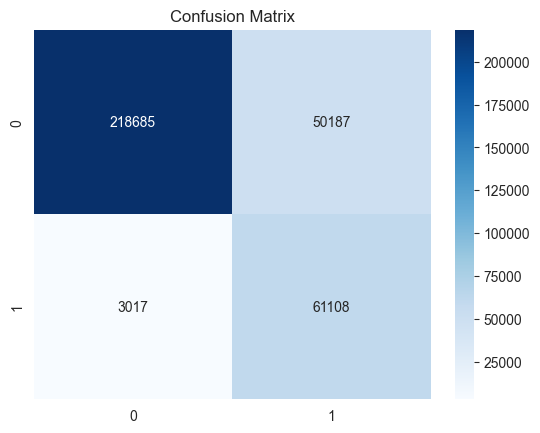

In [17]:
# Train the model
xgb = XGBClassifier(**best,
                    n_estimators=100,
                    random_state = 2024)
xgb.fit(X_train, y_train)

# Predictions
y_pred = xgb.predict(X_test)

# Evaluate the model
print('Metrics : ')
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Evaluate the model
print('Metrics : ')
print(accuracy_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

Metrics : 
0.8402267888299294
0.6967050507353779


### ROC Curve

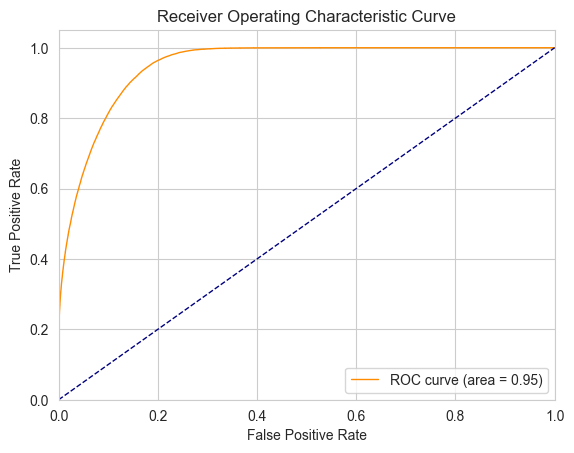

In [19]:
# roc curve
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

### Most Important Features

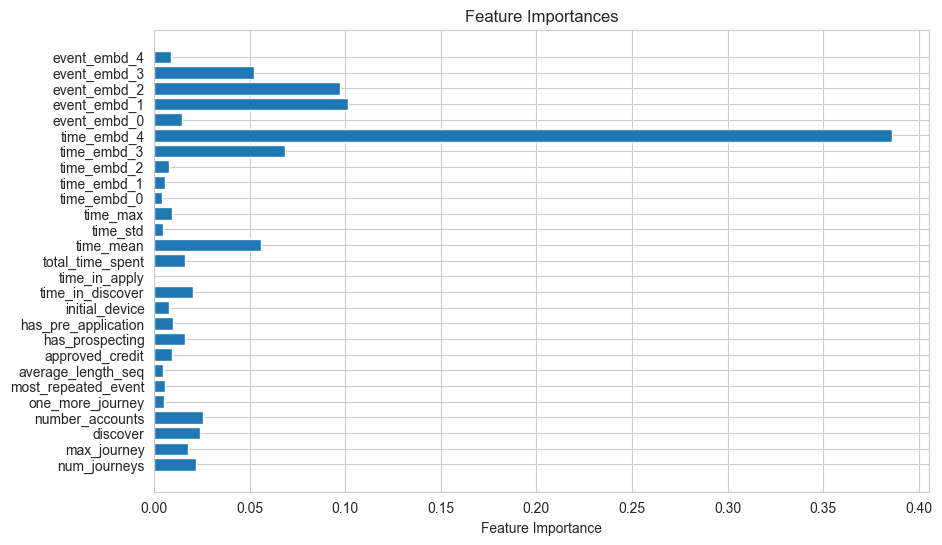

In [20]:
# Columns
x = list(new_dfx.drop(columns=['order_ships']).columns)
x = [str(x_i) for x_i in x]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(x, xgb.feature_importances_)
plt.xlabel('Feature Importance')
plt.title('Feature Importances')
plt.show()

### Cross Validation

For the original data set with the customers it takes approximately 12m 58s to run in my local machine.

In [21]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [22]:
# As X_train is the balanced data
X = pd.DataFrame(X_train, columns=new_dfx.drop(columns=['order_ships']).columns)
y = pd.DataFrame(y_train, columns=['order_ships'])

In [23]:
# Model
xgb = XGBClassifier(**best, 
                    n_estimators=100,
                    random_state = 2024)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

f1_scores = []
accuracy_scores = []

for train_index, test_index in cv.split(X, y):
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    numerical = X_train.loc[:,num_cols]
    scaler = StandardScaler()
    scaler.fit(numerical)
    
    numerical_tran = scaler.transform(numerical)
    numerical_test = scaler.transform(X_test[num_cols])

    # Concatenate the data to the final dataframe
    numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
    numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

    X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
    X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1)

    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

print('F1 Score:', np.mean(f1_scores))
print('F1 Score:', np.std(f1_scores))
print('Accuracy:', np.mean(accuracy_scores))
print('Accuracy:', np.std(accuracy_scores))

F1 Score: 0.9102921587304251
F1 Score: 0.00044454047209188647
Accuracy: 0.9015945381460488
Accuracy: 0.0005383239187543


In [24]:
lr = LogisticRegression(max_iter=1000, random_state=2024)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

F1 Score: 0.7915279502038327
Accuracy: 0.7743803362676752


In [25]:
# Model
lr = LogisticRegression(max_iter=1000, random_state=2024)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

f1_scores = []
accuracy_scores = []

for train_index, test_index in cv.split(X, y):
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    numerical = X_train.loc[:,num_cols]
    scaler = StandardScaler()
    scaler.fit(numerical)
    
    numerical_tran = scaler.transform(numerical)
    numerical_test = scaler.transform(X_test[num_cols])

    # Concatenate the data to the final dataframe
    numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
    numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

    X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
    X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1)

    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

print('F1 Score:', np.mean(f1_scores))
print('F1 Score:', np.std(f1_scores))
print('Accuracy:', np.mean(accuracy_scores))
print('Accuracy:', np.std(accuracy_scores))

F1 Score: 0.7923388020280078
F1 Score: 0.0006009214986766093
Accuracy: 0.7752872191679514
Accuracy: 0.0007006572903889705


In [26]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)
print('F1 Score:', f1_score(y_test, y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

F1 Score: 0.6898348151315433
Accuracy: 0.7066014556257307


In [27]:
# Model
gnb = GaussianNB()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)

f1_scores = []
accuracy_scores = []

for train_index, test_index in cv.split(X, y):
    
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index,:], y.iloc[test_index,:]

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)

    numerical = X_train.loc[:,num_cols]
    scaler = StandardScaler()
    scaler.fit(numerical)
    
    numerical_tran = scaler.transform(numerical)
    numerical_test = scaler.transform(X_test[num_cols])

    # Concatenate the data to the final dataframe
    numerical_tr = pd.DataFrame(numerical_tran, columns=num_cols)
    numerical_ts = pd.DataFrame(numerical_test, columns=num_cols)

    X_train = pd.concat([numerical_tr, X_train[categorical_cols], X_train[boolean_cols]] , axis=1)
    X_test = pd.concat([numerical_ts, X_test[categorical_cols], X_test[boolean_cols]] , axis=1)

    gnb.fit(X_train, y_train)
    y_pred = gnb.predict(X_test)
    
    f1_scores.append(f1_score(y_test, y_pred))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

print('F1 Score:', np.mean(f1_scores))
print('F1 Score:', np.std(f1_scores))
print('Accuracy:', np.mean(accuracy_scores))
print('Accuracy:', np.std(accuracy_scores))

F1 Score: 0.6883975263672959
F1 Score: 0.015921746101792342
Accuracy: 0.7063043264337023
Accuracy: 0.008143357888892378


## Ensemble Model

* This took 9 mins without the SVC model

In [28]:
# create the individual models
clf1 = LogisticRegression(random_state=2024)
clf2 = RandomForestClassifier(random_state=2024)
clf3 = GaussianNB()
clf4 = XGBClassifier(**best, 
                     n_estimators=100,
                     random_state=2024)
clf5 = LGBMClassifier(random_state=2024)
clf6 = GradientBoostingClassifier(random_state=2024)
clf7 = AdaBoostClassifier(random_state=2024)
clf6 = DecisionTreeClassifier(random_state=2024)

# create the ensemble model
eclf = VotingClassifier(
    estimators=[('lr', clf1),
                ('rf', clf2),
                ('gnb', clf3),
                ('xgb', clf4),
                ('lgbm', clf5),
                ('gbc', clf6),
                ('abc', clf7),
                ('dtc', clf6),],
                #('nn', model_1)],
    voting='soft')

# fit the ensemble model
eclf = eclf.fit(X_train, y_train)

# make predictions
y_pred = eclf.predict(X_test)

# evaluate the ensemble model
print('Metrics : ')
print(classification_report(y_test, y_pred))

[LightGBM] [Info] Number of positive: 860387, number of negative: 860388
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4390
[LightGBM] [Info] Number of data points in the train set: 1720775, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000001
[LightGBM] [Info] Start training from score -0.000001
Metrics : 
              precision    recall  f1-score   support

           0       0.99      0.86      0.92    215096
           1       0.88      0.99      0.93    215097

    accuracy                           0.93    430193
   macro avg       0.93      0.93      0.93    430193
weighted avg       0.93      0.93      0.93    430193



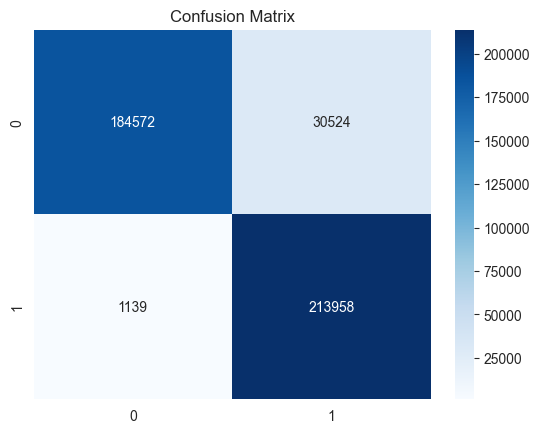

In [29]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [30]:
f1_score(y_test, y_pred)

0.9311043367951973

In [31]:
accuracy_score(y_test, y_pred)

0.9263981515273377